# R network exploration

This notebook consists of the ultilization of the Network Builder implemented in the previous TFG to build the dependencies network of **R** (***CRAN*** and ***Bioconductor***)

Build the network dependencies file for both repositories and show them as demonstration.

In [ ]:
%pip install -r Demo_requirements.txt

### Import the necessary libraries

In [12]:
import scipy
from time import time
import os
import psutil
import gc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Implementation of the network builder code

More information of the implementation details in:

- https://github.com/dab0012/olivia/blob/master/data/network_builder.ipynb (Previous TFG)

In [2]:

# Utility method for build_dependency_network
def add_chunk(df, G, dependent_field, dependency_field, filter_field=None, filter_value=None):
    """Utility method for build_dependency_network"""

    if filter_field:
        filtered = df[df[filter_field] == filter_value]
    else:
        filtered = df
    links = [(dependency, dependent) for (dependency, dependent) in zip(filtered[dependency_field], filtered[dependent_field])]
    G.add_edges_from(links)
    return G


# Utility method for build_dependency_network package
def build_dependency_network(input_file, output_file, chunk_size, dependent_field='Project Name', 
                                dependency_field='Dependency Name', filter_field=None, filter_value=None, verbose=True):
    """
    Builds a dependency network from a file with package dependencies information

    Reads from a CSV file and writes to a txt file with adjacency lists
    corresponding to network model. Compression methods are inferred from file
    extension (.gz and .bz2 are supported from NetworkX IO methods)

    Parameters
    ----------
    input_file : str
        Path to csv file with dependencies information
    output_file : str
        Path to write resulting network file
    chunk_size : int
        Amount of lines to be read at once from input_file in batch  processing.
    dependent_field : str
        DataFrame column Id for the dependent package
    dependency_field : str
        Dataframe column Id for the dependency package
    filter_field : str, optional
        If not None, only add records where filter_field equals filter_value
    filter_value : str, optional
        If not None, only add records where filter_field equals filter_value
    verbose: bool, optional
        If True, processing information is written to standard output.
    Returns
    -------
        None
    """

    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    
    try:
        vprint(f'Opening "{input_file}"... ', end='')

        # Obtain reader iterator
        reader = pd.read_csv(input_file, chunksize=chunk_size)
        vprint('OK')
        vprint('Initializing graph... ', end='')

        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')

        for i, chunk in enumerate(reader):
            # Add dependencies from chunk to G
            add_chunk(chunk, G, dependent_field, dependency_field, filter_field, filter_value)
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes,{len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb ')

        vprint('Done reading file')
        vprint(f'Saving network as "{output_file}"... ', end='')
        nx.write_adjlist(G, output_file)
        vprint('OK')
    except Exception as e:
        print('\n', e)


### Build Bioconductor dependencies network

**We configure the input and output file, and the other configuration parameters:**

In [6]:
# Building Bioconductor dependency network

source_file = "data" + os.sep + "bioconductor_scraped_dependencies.csv"
target_file = "data" + os.sep + "bioconductor_dependencies_net.bz2"
chunk_size = 1e6
filter_field = 'Platform'
filter_value = 'Bioconductor'

build_dependency_network(
    input_file=source_file,
    output_file=target_file,
    chunk_size=chunk_size,
    dependent_field ='Project Name',
    dependency_field='Dependency Name',
    filter_field=filter_field,
    filter_value=filter_value,
    verbose=True
)


Using process  psutil.Process(pid=15924, name='python3', status='running', started='10:24:28')
Opening "data/bioconductor_scraped_dependencies.csv"... OK
Initializing graph... OK
0.0M lines | 3444 nodes,27627 deps. (0s) 125.5Mb 
Done reading file
Saving network as "data/bioconductor_dependencies_net.bz2"... OK


**If everything has gone well we will have the network file generated** 

**We proceed to visualize the network:**

NOTE: 

- Generate the graph of the network, especially for dense networks you can take time.
- It is important to take into account the layout used.
- It is not recommended to use "draw_kamada_kawai" in very dense networks.


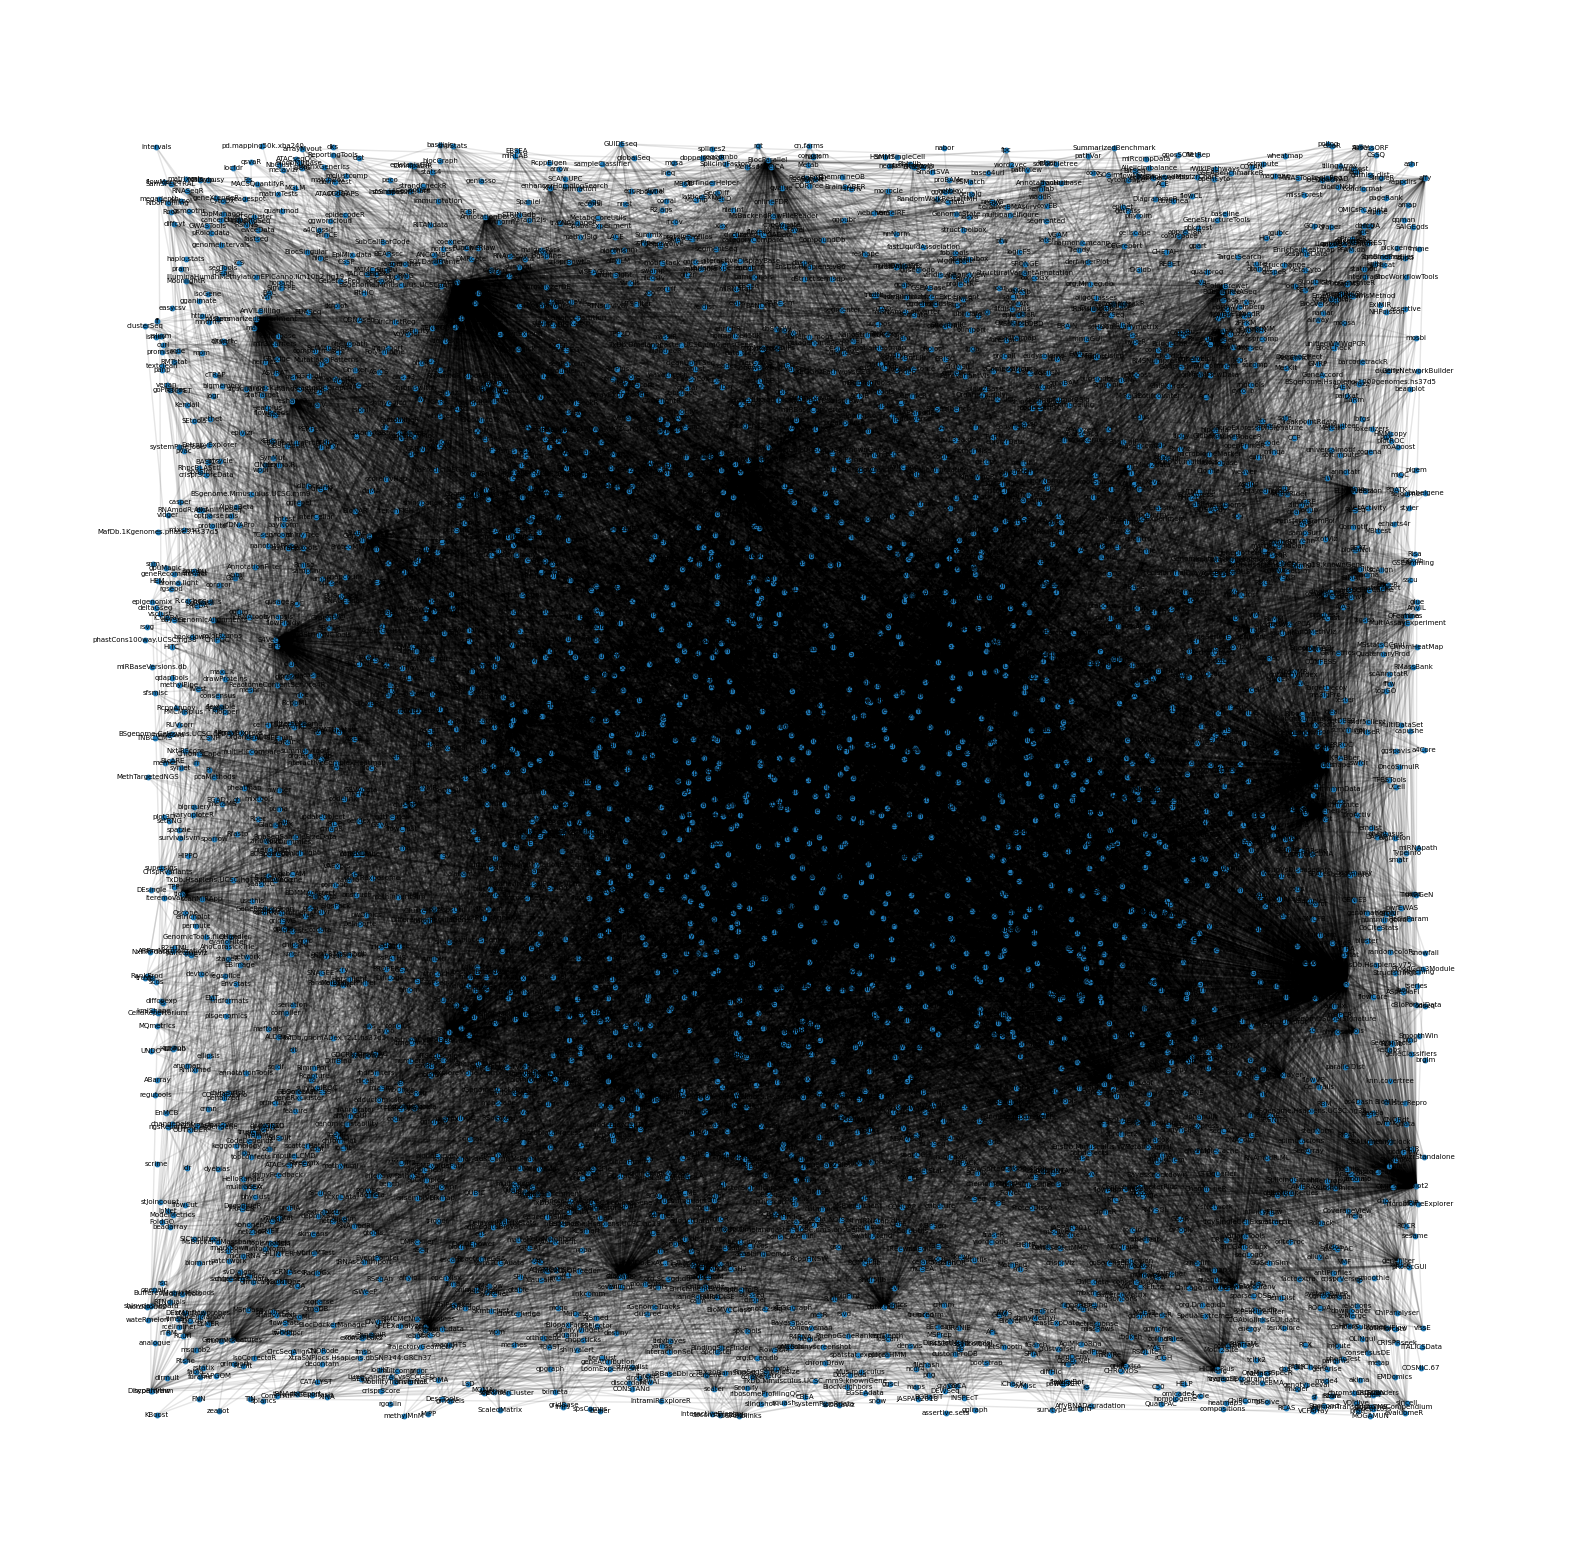

In [11]:
# Visualizing Bioconductor dependency network
target_file = "data" + os.sep + "bioconductor_dependencies_net.bz2"
G = nx.read_adjlist(target_file)

# Plotting the network using layout algorithms
plt.figure(figsize=(20,20))
pos = nx.random_layout(G)

# Show the labels
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.axis('off')
plt.show()

### Build CRAN dependencies network

In [7]:
# Building CRAN dependency network
source_file = "data" + os.sep + "CRAN_scraped_dependencies.csv"
target_file = "data" + os.sep + "CRAN_dependencies_net.bz2"
chunk_size = 1e6
filter_field = 'Platform'
filter_value = 'CRAN'

build_dependency_network(
    input_file=source_file,
    output_file=target_file,
    chunk_size=chunk_size,
    dependent_field ='Project Name',
    dependency_field='Dependency Name',
    filter_field=filter_field,
    filter_value=filter_value,
    verbose=True
)


Using process  psutil.Process(pid=15924, name='python3', status='running', started='10:24:28')
Opening "data/CRAN_scraped_dependencies.csv"... OK
Initializing graph... OK
0.0M lines | 18671 nodes,113297 deps. (0s) 177.4Mb 
Done reading file
Saving network as "data/CRAN_dependencies_net.bz2"... OK


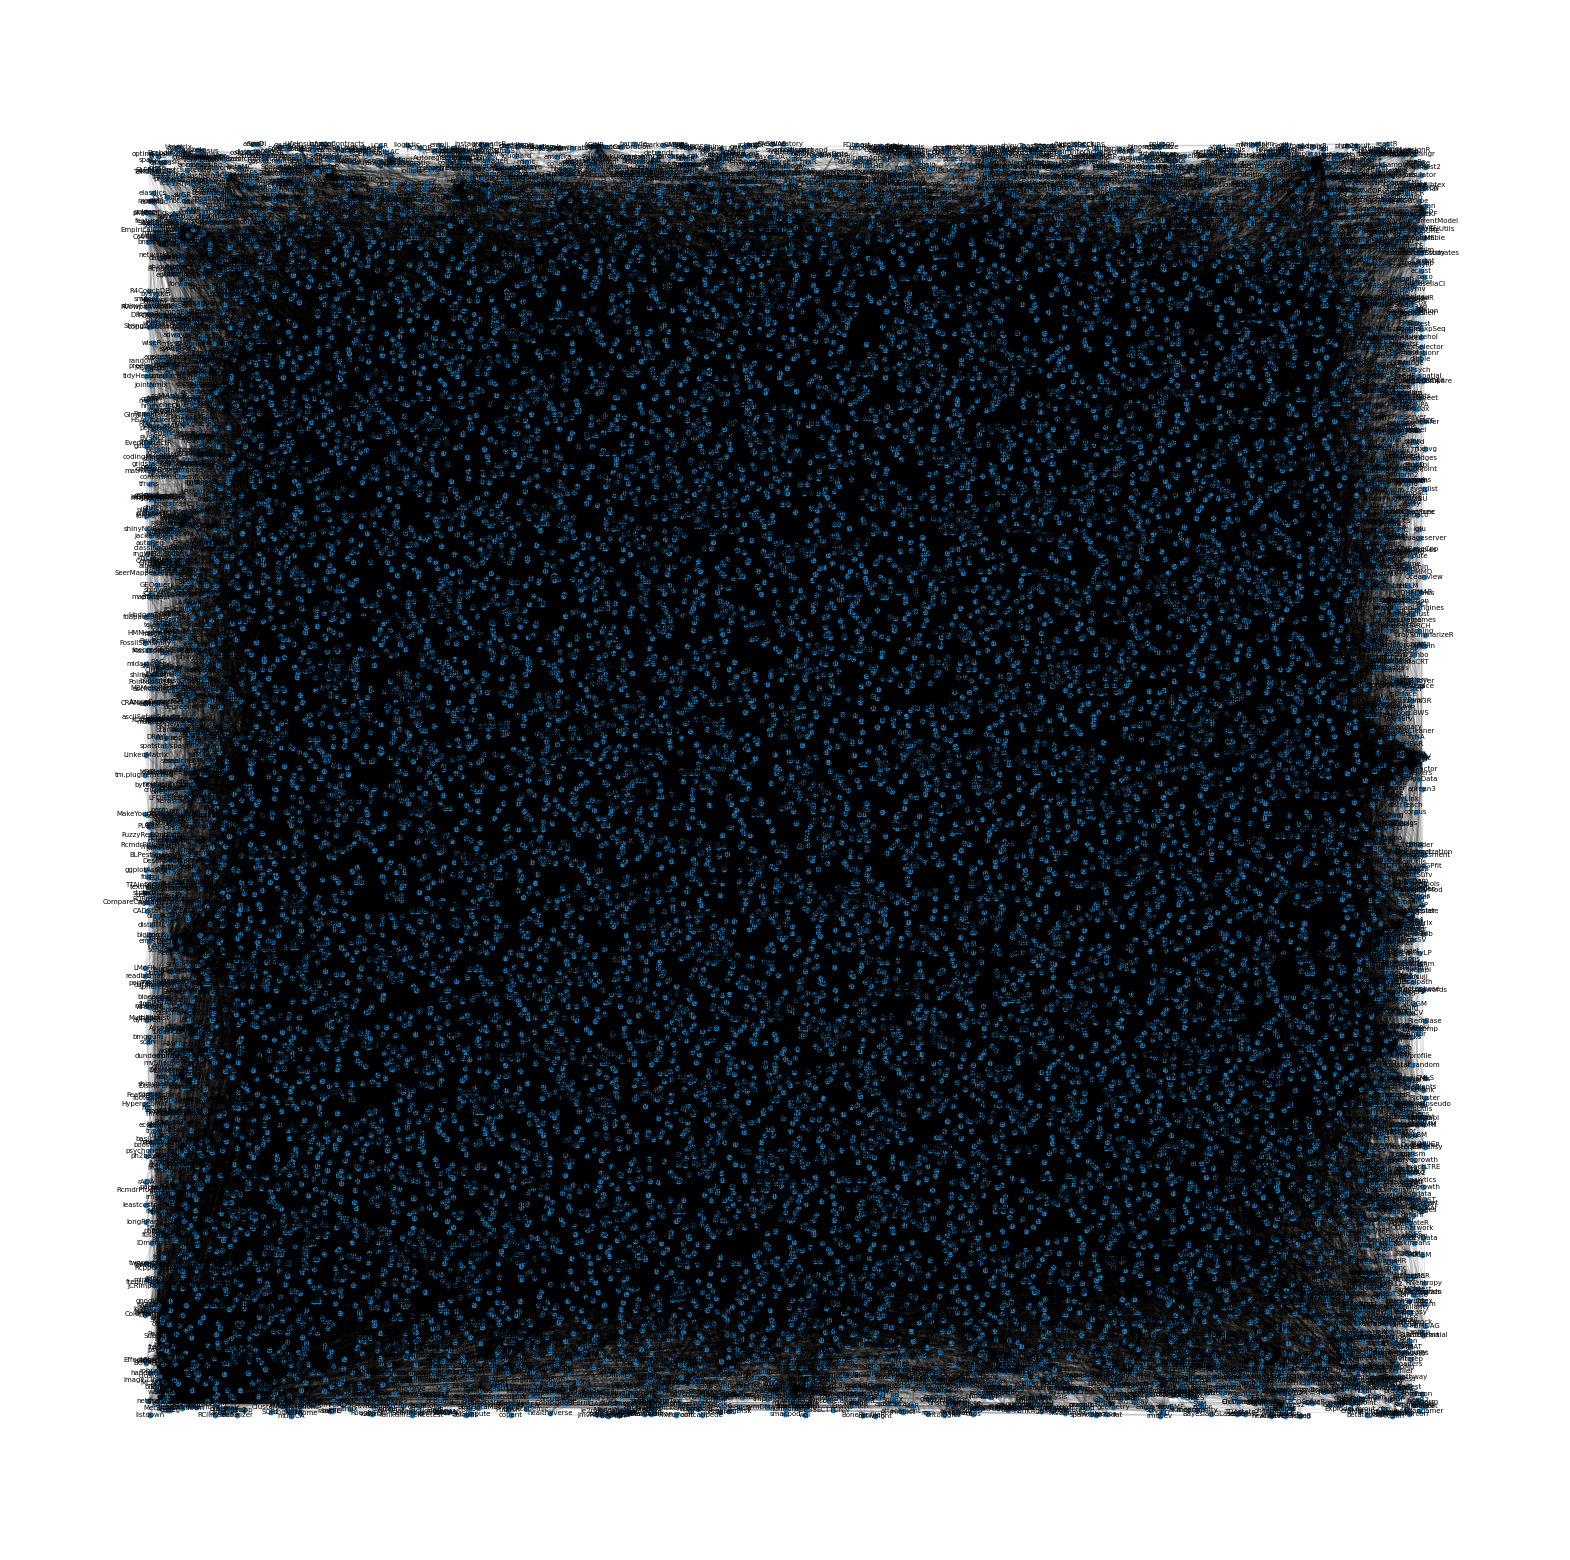

In [13]:
# Visualizing CRAN dependency network
target_file = "data" + os.sep + "CRAN_dependencies_net.bz2"
G = nx.read_adjlist(target_file)

# Plotting the network using layout algorithms
plt.figure(figsize=(20,20))
pos = nx.random_layout(G)

# Show the labels
nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.axis('off')
plt.show()